In [1]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit import Parameter, QuantumCircuit
from qiskit.circuit.library import EfficientSU2
from qiskit.opflow import PauliSumOp
from qiskit.quantum_info import Statevector
from surfer.gradient import ReverseGradient
from surfer.qfi import ReverseQFI

In [2]:
x = Parameter("x")
circuit = QuantumCircuit(1)
circuit.rx(x, 0)

values = np.array([0.2])

op = PauliSumOp.from_list([("Y", 1)])

### Model

Heisenberg on a line, ``EfficientSU2`` ansatz with 3 reps.

In [64]:
J = 0.25
g = -1
circuit = EfficientSU2(3, reps=1, entanglement="pairwise")
values = np.zeros(circuit.num_parameters)
for i in range(3):
    values[~(3 + i)] = np.pi / 2

op = PauliSumOp.from_list([
    ("ZII", g), ("IZI", g), ("IIZ", g), 
    ("XXI", J), ("IXX", J), ("YYI", J), ("IYY", J), ("ZZI", J), ("IZZ", J), 
])

Evolution time:

In [4]:
time = 1

In [5]:
def solve(A, b, x0=None):
    x0 = x0 or np.zeros_like(b)
    return COBYLA().minimize(lambda x: x.dot(A.dot(x)) - 2 * b.dot(x), x0).x

### Expected state

In [17]:
initial = Statevector(circuit.bind_parameters(values))
expected = scipy.linalg.expm(-op.to_matrix() * time).dot(initial)
sqrtZ = np.sqrt(initial.data.dot(scipy.linalg.expm(-2 * op.to_matrix() * time).dot(initial.data)))
print("Partition function:", sqrtZ ** 2)
print("State:\n", expected)
expected_normalized = expected / np.linalg.norm(expected)
print("Normalized state:\n", expected_normalized)

Partition function: (54.418721610889506+0j)
State:
 [ 4.67711802+0.j  5.57447016+0.j -0.27679758+0.j  0.35055944+0.j
  0.75333176+0.j  0.83524506+0.j -0.02563885+0.j  0.05711227+0.j]
Normalized state:
 [ 0.63402176+0.j  0.75566521+0.j -0.03752219+0.j  0.04752121+0.j
  0.10212031+0.j  0.11322433+0.j -0.00347556+0.j  0.00774204+0.j]


### Plain McLachlan 

Normalized states only!

In [7]:
parameters = [values]
num_timesteps = 100
dt = time / num_timesteps

for _ in range(num_timesteps):
    theta = parameters[-1]
    qgt = ReverseQFI().compute(circuit, theta) / 4
    b = -ReverseGradient().compute(op, circuit, theta) / 2
    update = solve(qgt, b)
    parameters.append(theta + dt * update)

In [8]:
bound = circuit.bind_parameters(parameters[-1])
standard = Statevector(bound)
print(standard)

Statevector([ 0.63193177+3.10707597e-03j,  0.75926497+3.72442569e-03j,
             -0.02134474+5.00147917e-04j,  0.0348812 -5.21646120e-05j,
              0.09530585+3.18478701e-04j,  0.11503824+3.68763853e-04j,
              0.01215725-1.34644860e-05j, -0.00422198+1.20981947e-04j],
            dims=(2, 2, 2))


In [9]:
np.linalg.norm(standard - expected_normalized)

0.030001422657526044

### Unnormalized

In [56]:
def qite(ansatz, initial_values, time):
    norms = [1]
    parameters = [initial_values]
    num_timesteps = 100
    dt = time / num_timesteps

    for _ in range(num_timesteps):
        theta = parameters[-1]
        zeta = norms[-1]

        energy = Statevector(circuit.bind_parameters(theta)).expectation_value(op.primitive).real
        norms.append(zeta - dt * energy * zeta)

        qgt = ReverseQFI().compute(circuit, theta) / 4
        b = -ReverseGradient().compute(op, circuit, theta) / 2

        update = solve(qgt, b)
        parameters.append(theta + dt * update)
        
    return parameters, norms

In [21]:
parameters, norms = qite(circuit, values, time)

In [22]:
bound = circuit.bind_parameters(parameters[-1])
standard = Statevector(bound)
print(standard)

Statevector([ 0.63193177+3.10707597e-03j,  0.75926497+3.72442569e-03j,
             -0.02134474+5.00147917e-04j,  0.0348812 -5.21646120e-05j,
              0.09530585+3.18478701e-04j,  0.11503824+3.68763853e-04j,
              0.01215725-1.34644860e-05j, -0.00422198+1.20981947e-04j],
            dims=(2, 2, 2))


In [23]:
unnorm = norms[-1] * standard

In [24]:
np.linalg.norm(unnorm - expected) / np.linalg.norm(unnorm)

0.04670274692923428

In [25]:
np.linalg.norm(standard - expected_normalized) 

0.030001422657526044

In [26]:
np.abs(sqrtZ ** 2 - norms[-1] ** 2) / np.abs(sqrtZ ** 2)

0.06711079207068447

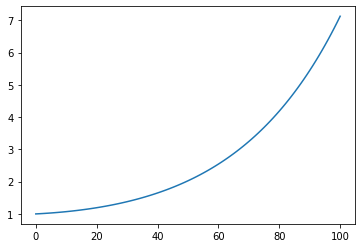

In [27]:
plt.plot(norms)

### Thermodynamic observables

In [65]:
observable = PauliSumOp.from_list([("ZZI", 1)])

temperature = 1
time = 1 / temperature

Reference value:

In [66]:
expH = scipy.linalg.expm(-time * op.to_matrix())
exact = np.trace(expH.dot(observable.to_matrix())) / np.trace(expH)

In [67]:
exact

(0.23458893070790507+0j)

In [68]:
def random_initial_values():
    num_qubits = circuit.num_qubits
    random_angles = 2 * np.pi * (np.random.random(num_qubits) - 0.5)  # in [-pi, pi]
    initial_values = np.zeros(circuit.num_parameters)
    initial_values[-2 * num_qubits:-num_qubits] = random_angles
    
    return initial_values

Draw samples:

In [69]:
num_samples = 90
parameters = []
norms = []

In [74]:
for i in range(90):
    print(f"Sample {i + 1}/{num_samples}", end="\r")
    p, n = qite(circuit, random_initial_values(), time=time/2)
    parameters.append(p[-1])
    norms.append(n[-1])

Compute average

In [75]:
averages = [Statevector(circuit.bind_parameters(theta)).expectation_value(observable) for theta in parameters]

In [76]:
ensemble_average = np.sum(avg * Z for avg, Z in zip(averages, norms)) / np.sum(norms)

<ipython-input-76-fd346114f77f>:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  ensemble_average = np.sum(avg * Z for avg, Z in zip(averages, norms)) / np.sum(norms)


In [77]:
ensemble_average

(-0.018924755640222016+0j)

In [78]:
averages

[(0.19772607626447172+0j),
 (0.7072954251618648+0j),
 (-0.6160363632524805+0j),
 (-0.6411700048970977+0j),
 (0.6308503065134434+0j),
 (-0.384839854564967+0j),
 (-0.5885230261336699+0j),
 (-0.4576625396632696+0j),
 (0.5290750804794178+0j),
 (0.027921961375856594+0j),
 (-0.3704432695583698+0j),
 (0.39618576341008954+0j),
 (-0.9787075826498338+0j),
 (-0.7201269795005678+0j),
 (-0.3167782389702797+0j),
 (0.40536008283953595+0j),
 (0.9764952673305234+0j),
 (0.38856404087839963+0j),
 (-0.882225372512378+0j),
 (-0.5218578073167035+0j),
 (0.06713248248099231+0j),
 (-0.9167463546651184+0j),
 (-0.9861324110253307+0j),
 (0.348197263770477+0j),
 (-0.4357684048055993+0j),
 (-0.723209913587105+0j),
 (-0.12736913375777323+0j),
 (0.8904599938470896+0j),
 (0.5856830073642103+0j),
 (0.44033190648935244+0j),
 (-0.8814460988016181+0j),
 (-0.5564097717506441+0j),
 (0.6539639144125622+0j),
 (0.7524281658230115+0j),
 (-0.8213317001623818+0j),
 (0.7656578524694281+0j),
 (-0.24339497859775688+0j),
 (0.31385038

In [86]:
from qiskit.visualization import plot_bloch_multivector

In [142]:
theta = np.random.uniform(-np.pi, np.pi, 1)[0]
v = np.random.uniform(0, 1, 1)[0]
phi = np.arccos(1 - 2 * v)
# phi = np.pi / 2
theta = np.pi / 2
circuit = QuantumCircuit(2)
circuit.h(0)
circuit.rz(theta, 0)
circuit.ry(phi, 0)

In [187]:
circuit = QuantumCircuit(1)
theta = 0
phi = -np.pi / 2
circuit.u(theta, phi, 0, 0)

In [188]:
state = Statevector(circuit)

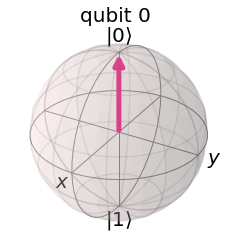

In [189]:
plot_bloch_multivector(state.data)

In [204]:
def coords(theta, phi):
    return np.array([
        np.sin(phi) * np.cos(theta),
        np.sin(phi) * np.sin(theta),
        np.cos(phi)
    ])

In [199]:
n = 500
theta = np.random.uniform(0, 2 * np.pi, n)
v = np.random.uniform(0, 1, n)
phi = np.arccos(1 - 2 * v)

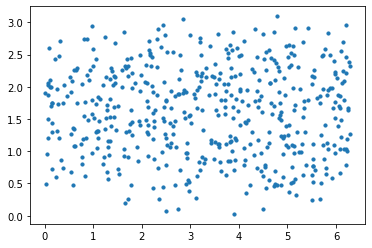

In [200]:
plt.scatter(theta, phi, s=10)

In [238]:
theta = np.random.uniform(0, 2 * np.pi, 1)[0]
v = np.random.uniform(0, 1, 1)[0]
phi = np.arccos(1 - 2 * v)

theta = 3 * np.pi / 2
# theta = 0
phi = 3 * np.pi / 4
circuit = QuantumCircuit(1)
circuit.ry(phi, 0)
circuit.rz(theta, 0)

In [239]:
print(phi, theta)
print(coords(phi, theta))

2.356194490192345 4.71238898038469
[ 7.07106781e-01 -7.07106781e-01 -1.83697020e-16]


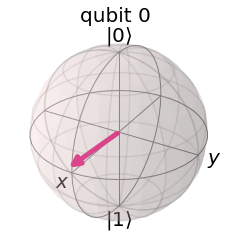

In [240]:
state = Statevector(circuit)
plot_bloch_multivector(state.data)

In [249]:
print(state)
print(np.array([np.exp(-0.5j * theta) * np.cos(phi / 2), np.exp(0.5j * theta) * np.sin(phi / 2)]))

Statevector([-0.27059805-0.27059805j, -0.65328148+0.65328148j],
            dims=(2,))
[-0.27059805-0.27059805j -0.65328148+0.65328148j]
